# Wavelet Transform Coefficient Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
import pywt

from crypr.util import get_project_path
from crypr.build import make_features, data_to_supervised

In [2]:
SYM = 'BTC'
TARGET = 'close'
Tx = 72
Ty = 1
TEST_SIZE = 0.05

data_path = join(get_project_path(), 'data', 'raw', SYM + '.csv')

data = pd.read_csv(data_path, index_col=0)
data.head()

,volumeto,volumefrom,open,high,close,low,time,timestamp
0,9030127.25,1190.78,7559.41,7576.06,7542.34,7542.33,1533250800,2018-08-03 01:00:00
1,58084509.89,7802.88,7542.34,7542.49,7396.84,7372.78,1533254400,2018-08-03 02:00:00
2,42708264.07,5797.35,7396.84,7399.40,7349.18,7326.15,1533258000,2018-08-03 03:00:00
3,21147173.02,2871.34,7349.50,7364.60,7360.55,7325.00,1533261600,2018-08-03 04:00:00
4,12940986.94,1756.12,7360.42,7367.82,7339.11,7339.04,1533265200,2018-08-03 05:00:00


In [3]:
"""
Get percent change feature and target data.
"""
df = make_features(input_df=data, target_col='close')
p(df.head())
X, y = data_to_supervised(input_df=df[['target__close']], target_ix=-1, Tx=Tx, Ty=Ty)
p(X.shape, y.shape)
X.head()

   target__close
0      -1.929110
1      -0.644329
2       0.154711
3      -0.291283
4       0.360807
(5926, 72) (5926, 1)


,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
72,-1.929110,-0.644329,0.154711,-0.291283,0.360807,-0.445993,0.457128,0.426811,-0.206551,-0.276332,...,-0.565566,1.106856,0.075008,-0.288833,0.430289,0.014656,0.514315,-0.065677,-0.291490,0.038354
73,-0.644329,0.154711,-0.291283,0.360807,-0.445993,0.457128,0.426811,-0.206551,-0.276332,-0.037082,...,1.106856,0.075008,-0.288833,0.430289,0.014656,0.514315,-0.065677,-0.291490,0.038354,0.217966
74,0.154711,-0.291283,0.360807,-0.445993,0.457128,0.426811,-0.206551,-0.276332,-0.037082,0.118761,...,0.075008,-0.288833,0.430289,0.014656,0.514315,-0.065677,-0.291490,0.038354,0.217966,1.132941
75,-0.291283,0.360807,-0.445993,0.457128,0.426811,-0.206551,-0.276332,-0.037082,0.118761,0.533250,...,-0.288833,0.430289,0.014656,0.514315,-0.065677,-0.291490,0.038354,0.217966,1.132941,0.126792
76,0.360807,-0.445993,0.457128,0.426811,-0.206551,-0.276332,-0.037082,0.118761,0.533250,0.452120,...,0.430289,0.014656,0.514315,-0.065677,-0.291490,0.038354,0.217966,1.132941,0.126792,-0.569769


In [4]:
"""
Confirm data reshape and target/feature creation was done correctly.
"""
y_values_except_last = np.squeeze(y.iloc[:-1].values)
t_minus_1_x_values_except_first = X.iloc[1:,-1].values

y_values_except_last.all() == t_minus_1_x_values_except_first.all()

True

In [5]:
"""
For comparing different transformations
"""
sample_ix = 1000

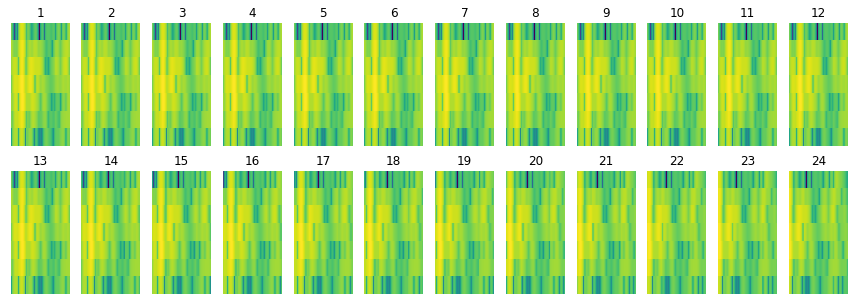

In [6]:
"""
Spectrogram Analysis
"""
rows = 2
cols = 12

fig, ax = plt.subplots(rows,cols, figsize=(15,5))

for r in range(rows):
    for c in range(cols):
        plt.sca(ax[r][c])
        pxx, freqs, bins, im = plt.specgram(X.iloc[(sample_ix + r*c)], 12, 1, noverlap=11)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.title((c + 1) + r*cols)
sns.despine(left=True, bottom=True)
plt.show()

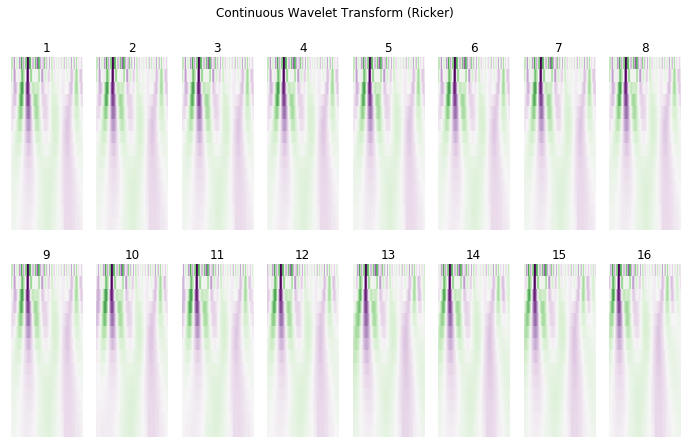

In [7]:
"""
CWT Ricker
"""
N = 14
# T = 1.0 / N
# START=1000
widths = np.arange(1, (N + 1))

rows = 2
cols = 8
fig, ax = plt.subplots(rows, cols, figsize=(12, 7))
for r in range(rows):
    for c in range(cols):
        plt.sca(ax[r][c])
        cwtmatr = signal.cwt(X.iloc[(sample_ix + r*c)], wavelet=signal.ricker, widths=widths)
        plt.imshow(cwtmatr, extent=[-1, 1, 1, (N + 1)], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.title((c + 1) + r*cols)
sns.despine(left=True, bottom=True)
plt.suptitle('Continuous Wavelet Transform (Ricker)')
plt.show() 

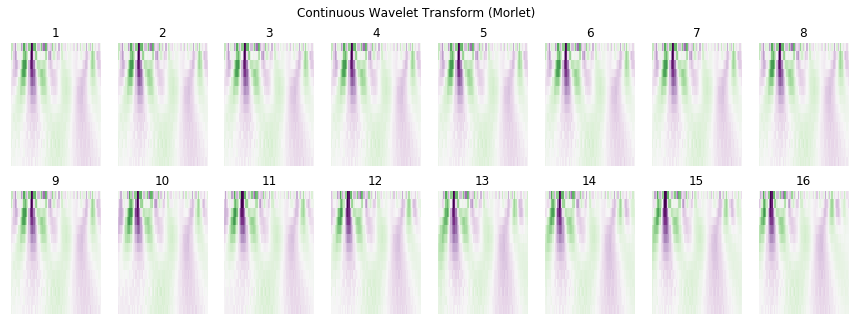

In [8]:
"""
CWT Morlet Transform
"""

rows = 2
cols = 8

fig, ax = plt.subplots(rows,cols, figsize=(15,5))

for r in range(rows):
    for c in range(cols):
        plt.sca(ax[r][c])
        cwtmatr, freqs = pywt.cwt(X.iloc[(sample_ix + r*c)], scales=widths, wavelet='mexh')
        plt.imshow(cwtmatr, extent=[-1, 1, 1, (N + 1)], cmap='PRGn', aspect='auto',
                   vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.title((c + 1) + r*cols)
sns.despine(left=True, bottom=True)
plt.suptitle('Continuous Wavelet Transform (Morlet)')
plt.show() 

In [9]:
"""
Apply the wave transformation to the feature data.
"""
wt_type = 'MORLET'
p('Applying {} transform ...'.format(wt_type))
N = 28
widths = np.arange(1, (N + 1))

if wt_type == 'RICKER':
    wt_transform_fun = lambda x: signal.cwt(x, wavelet=signal.ricker, widths=widths)
elif wt_type == 'MORLET':
    wt_transform_fun = lambda x: pywt.cwt(x, scales=widths, wavelet='morl')[0]
else:
    raise NotImplementedError
    
X_wt_coef = np.apply_along_axis(func1d=wt_transform_fun, axis=-1, arr=X)

p('Old shape: ', X.shape)
p('New shape: ', X_wt_coef.shape)

Applying MORLET transform ...
Old shape:  (5926, 72)
New shape:  (5926, 28, 72)


In [10]:
"""
Train Test Split.
"""
X_train, X_test, y_train, y_test = train_test_split(X_wt_coef, y, test_size=TEST_SIZE, shuffle=False)

In [11]:
"""
Save data.
"""
output_dir = join(get_project_path(), 'data', 'processed')

np.save(arr=X_train, allow_pickle=True, 
        file=join(output_dir, 'X_train_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx)))
np.save(arr=X_test, allow_pickle=True,
        file=join(output_dir, 'X_test_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx)))
np.save(arr=y_train, allow_pickle=True,
        file=join(output_dir, 'y_train_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx)))
np.save(arr=y_test, allow_pickle=True,
        file=join(output_dir, 'y_test_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx)))